This notebook shows how to train and validate a classifier model that can distinguish between two major groups within the plum genus (*Prunus*)

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug  8 18:18:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.7 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/DL_images/CP_NUC/model_dev_trim1

/content/drive/MyDrive/DL_images/CP_NUC/model_dev_trim1


In [ ]:
ls

SC_trim1/  TR_trim1/


This shows the number of images in each of the two categories (SC = solitary / corymbose; TR = tropical racemose). Each of these sets of images has been trimmed using the script "Data_Processing-trimming_cpnuc.ipynb"

In [ ]:
ls -l SC_trim1/ | wc

   2031   18272  193509


In [ ]:
ls -l TR_trim1/ | wc

   2200   19793  211412


In [ ]:
path = '/content/drive/MyDrive/DL_images/CP_NUC/model_dev_trim1'

In [ ]:
fns = get_image_files(path)
fns

(#4229) [Path('/content/drive/MyDrive/DL_images/CP_NUC/model_dev_trim1/SC_trim1/cerasoides_c228dd99-0d0c-4b5f-907f-7e6db29189d7.jpg'),Path('/content/drive/MyDrive/DL_images/CP_NUC/model_dev_trim1/SC_trim1/cerasoides_c74d3958-d47e-431b-8d2f-9adde3de3abd.jpg'),Path('/content/drive/MyDrive/DL_images/CP_NUC/model_dev_trim1/SC_trim1/cerasoides_cba87a33-53d1-4818-8793-a362513c8a94.jpg'),Path('/content/drive/MyDrive/DL_images/CP_NUC/model_dev_trim1/SC_trim1/cerasoides_cce75b07-dae8-4246-ae26-dab581839cc3.jpg'),Path('/content/drive/MyDrive/DL_images/CP_NUC/model_dev_trim1/SC_trim1/cerasoides_d171172d-46c3-4487-9077-e0048b7870e2.jpg'),Path('/content/drive/MyDrive/DL_images/CP_NUC/model_dev_trim1/SC_trim1/cerasoides_e10f584a-87eb-46c2-b6a8-3ebed026b445.jpg'),Path('/content/drive/MyDrive/DL_images/CP_NUC/model_dev_trim1/SC_trim1/cerasoides_e14340ea-0296-4e00-98d2-d804933a38c0.jpg'),Path('/content/drive/MyDrive/DL_images/CP_NUC/model_dev_trim1/SC_trim1/cerasoides_e6ee68a7-b6e4-4f78-89d5-d478fbb643

In [ ]:
failed = verify_images(fns)
print(failed)

[]


The following blocks set parameters for the model and list where the labeled data are located

In [ ]:
pilot_cpnuc = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

In [ ]:
dls = pilot_cpnuc.dataloaders(path)

In [ ]:
pilot_cpnuc = pilot_cpnuc.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())


dls = pilot_cpnuc.dataloaders(path)

In [ ]:
from fastai.callback.fp16 import *



The model used is built on a resnet50 architecture and is trained until the error rate is < 0.03

In [ ]:
learn_v5 = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn_v5.fine_tune(24, freeze_epochs=3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.612219,0.296576,0.094675,01:52
1,0.467946,0.337555,0.093491,01:54
2,0.375065,0.231520,0.079290,01:49


epoch,train_loss,valid_loss,error_rate,time
0,0.235117,0.195589,0.065089,01:51
1,0.179293,0.165462,0.052071,01:53
2,0.153596,0.147912,0.050888,01:55
3,0.120610,0.120497,0.044970,01:54
4,0.115433,0.187025,0.057988,01:53
5,0.104425,0.132140,0.040237,01:56
6,0.086275,0.180834,0.054438,01:53
7,0.079946,0.158907,0.053254,01:53
8,0.075477,0.133917,0.039053,01:50
9,0.071399,0.145920,0.052071,01:55


The following command saves the model for use later on

In [ ]:
learn_v5.export('prunus_res50_cpnuc_v5_trim1_fp16_24epochs.pkl')

Below is the confusion matrix showing the accuracy of the model under test data

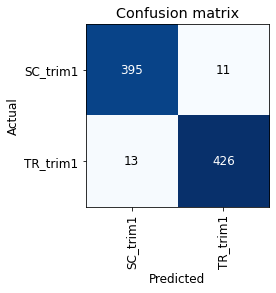

In [ ]:
interp_v5 = ClassificationInterpretation.from_learner(learn_v5)
interp_v5.plot_confusion_matrix()